# Eexercises Week3: GP Classification and Variational inference for GP classification

## Learning objectives

After completing this lab exercise, you should be able to:
- Implement variational inference for GP classification and hyperparameter selection
- Know how to apply an automatic differentiation framework, such as Tensorflow, in the GP context

**/!\ Important Notes /!\**

* In the first part of this assignment, we will use an automatic differentiation framework to optimize the ELBO objective that arises in variational inference. Most standard optimization methods require access to the gradients of the optimized function, and if you were able to derive them by hand for this particular task, you could optimize using standard numpy/scipy. Nowadays, however, these automatic differentiation frameworks make things quite a lot easier, providing easy gradients and integrates them with different standard optimizers. This assignment is designed with Tensorflow, but if you wish, you can try implementing everything with a different framework, such as Pytorch or Jax (we suggest to stick with Tensorflow unless you feel sure about yourself). 
* All exercises must be solved using only basic mathematical operations (exp, erf, ...) and linear algebra routines (solve, matrix-vector products, ...)
* Common gotcha: getting the shape of your arrays wrong e.g. (N, 1) vs (1, N) vs (N,); check that all your functions get and return arrays of the correct shapes!

**A mini tutorial on automatic differentiation**

When using an automatic differentiation framework to optimize a function
\[
\begin{equation*}
f: \theta \to f(\theta)
\end{equation*}
\]
the variable $\theta$ and/or the operations mapping from $\theta$ to $f(\theta)$ must be defined using operators from the framework.

For example to optimize $e^{\theta}+e^{-\theta}$ with respect to $\theta$ with tensorflow, you need to proceed as follows: (See tutorial on gradient calculation in tensorflow: https://www.tensorflow.org/api_docs/python/tf/GradientTape)

In [16]:
import tensorflow as tf

# define the theta variable
theta = tf.Variable(1.0, dtype=tf.float64)

# define the function
f = lambda x: tf.exp(x) + tf.exp(-x) # note the use of the tf.exp operation (not np.exp)

# run the optimization
for t in range(1000):
    # at each step, compute the gradients
    with tf.GradientTape() as tape:
        tape.watch(theta)
        loss = f(theta)
    
    gradient = tape.gradient(loss, theta)
    
    # apply the variable update (gradient descent)
    theta.assign(theta - 0.01*gradient)
    
    if t % 100 == 0:
        print(t, theta)

print(tf.__version__)

0 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.976495976127124>
100 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.11997260765615987>
200 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.01589141680262445>
300 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.0021074677296479584>
400 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.000279491329621495>
500 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.706601576651237e-05>
600 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.9156785491697575e-06>
700 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=6.519151061066394e-07>
800 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=8.64566918588179e-08>
900 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.1465848082993902e-08>
2.18.0


In [17]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

# Variational inference for Gaussian Process Classification (6 points)

We are interested in the problem of Gaussian Process classification. 

We have some data $\mathcal{D} = \left\lbrace {\bf x}_n, y_n \right\rbrace_{n=1}^N$, with $y_n \in \{-1,1\}$.

We want to perform inference in the following generative model:
$$
\begin{align*}
f(\cdot) &\sim GP(0, k) \\
f_n &= f({\bf x}_n) \qquad &&(f_n\in \mathbb{R}) \\
\theta_n &= \phi(f_n) \qquad &&(\theta_n\in (0, 1)) \\
\{-1,1\} \ni y_n  &\sim \text{Bernoulli}(p=\theta_n)
\end{align*}
$$
with $\phi$ the normal cumulative distribution function $\phi(x)=\int_{-\infty}^x {\cal N}(u; 0,1)\,{\rm d}u$.

We can compactly write the likelihood as
$$ p(y_n|f(\cdot),{\bf x}_n) = p(y_n|f_n) = \phi(y_n * f_n).$$


We will here use a Squared Exponential kernel, with two parameters: lengthscale $\ell$ and variance $\sigma^2$.


The posterior is $p({\bf f}|{\bf y}) \propto p({\bf y}|{\bf f})p({\bf f})$ is intractable, hence we resort to an approximate inference scheme called variational inference.

This turns inference into optimization. We optimize the distance $d(q) = \operatorname{KL}[q({\bf f})\|p({\bf f}|{\bf y})] \geq 0$, with respect to a distribution $q({\bf f})$

We parameterize $q$ through the mean vector $m$ and the Cholesky factor of the covariance $L$: i.e. $q({\bf f})={\cal N}({\bf f}|m, S=LL^\top)$

In practice we optimize the ELBO:
$${\cal L}(q) = \log p({\bf y})-d(q) = 
\underbrace{\mathbb{E}_q\big[ \log p({\bf y}|{\bf f}) \big]}_{\text{VE}} 
- \underbrace{\operatorname{KL}[q({\bf f})\|p({\bf f})]}_{\text{KL}}$$

We split the ELBO into two terms
* variational expectations (VE), or data fit term
* Kullback-Leibler (KL) from prior to approximate posterior, or regularization term


### Task 1a: KL divergence 

For a prior $p({\bf f})={\cal N}({\bf f}|0,K)$ and a variational distribution $q({\bf f})={\cal N}({\bf f}|m, S=LL^\top)$, compute the KL divergence $\operatorname{KL}[q({\bf f})\|p({\bf f})]$


You can use the formula:
$$
\begin{align*}
&\operatorname{KL}\left[\mathcal{N}(\mu_0,\Sigma_0) \| \mathcal{N}(\mu_1,\Sigma_1)\right] \\ 
 &= \frac{1}{2}\left(
    \operatorname{tr}\left(\Sigma_1^{-1}\Sigma_0\right) +
    \left(\mu_1 - \mu_0\right)^\top \Sigma_1^{-1}\left(\mu_1 - \mu_0\right) - k +
    \ln\frac{|\Sigma_1|}{|\Sigma_0|}
  \right),\; \text{(source: Wikipedia)}\\
  &= \dots \quad \text{ (Bonus: can you fill the gap?)}\\
    &=
  \frac{1}{2}\left(
    \sum_{ij} (L_1^{-1}L_0)^2_{ij} +
    \|L_1^{-1}\left(\mu_1 - \mu_0\right)\|^2 - k + 2\sum_{i}
    \big(\ln |L_{1,ii}|- \ln|L_{0,ii}|\big)
  \right),
  \end{align*}
  $$
where we have adapted it to the (mean, Cholesky) parameterization of the multivariate Gaussian distributions, i.e., $\Sigma_0 = L_0 L_0^\top$ and $\Sigma_1 = L_1 L_1^\top$.

#### Important note
In the last line of the equation above we simplified the computation of the log-determinant to a sum over the logarithms of the diagonal elements. This is specific to the parameterization using Cholesky factors of the covariances, which implies that $L_0$ and $L_1$ are *lower-triangular* matrices with non-negative elements on the diagonal! If not, we cannot expect this function to perform correctly. In this function, you can assume that the inputs are valid Cholesky factors, but later on we will need to ensure this explicitly. 

In [18]:
def KL(m0, L0, m1, L1):
    """ returns the KL divergence between N(m0, S0) and N(m1, S1)
    
    arguments:
    m0, m1   -- N × 1, mean vector
    L0, L1   -- N × N, Cholesky factor of a covariance matrix 
    returns a scalar
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    # MODEL SOLUTION #
    
    term1 = tf.reduce_sum(tf.square(tf.linalg.solve(L1, L0)))
    term2 = tf.reduce_sum(tf.square(tf.linalg.solve(L1, (m1-m0))))
    k = tf.cast(tf.shape(L0)[0], tf.float64)
    term3inner = tf.math.log(tf.abs(tf.linalg.diag_part(L1))) - tf.math.log(tf.abs(tf.linalg.diag_part(L0)))
    return 0.5 * (term1 + term2 - k + 2 * tf.reduce_sum(term3inner))



Let's check that the KL is coded properly.

For instance, noting $q_0(f) = N(f|0, I)$ and $q_1(f) = N(f|0, 2I)$, 
we should have:
* $\operatorname{KL}[q_0\|q_0] = 0$
* $\operatorname{KL}[q_0\|q_1] > 0$ 



In [19]:
def test_KL(K = 10):
    m_0 = np.random.randn(K, 1)
    m_1 = np.random.randn(K, 1)
    L_0 = np.tril(np.random.randn(K, K)) + 4*np.eye(K)# Cholesky matrices should be lower-triangular
    L_1 = np.tril(np.random.randn(K, K)) + 4*np.eye(K)# with positive elements on the diagonal
    
    assert abs(KL(m_0, L_0, m_0, L_0)) < 1e-10  # approx. == 0
    assert KL(m_0, L_0, m_1, L_1) > 0


test_KL()

### Task 1b: Variational expectations

To compute the variational expectations $\mathbb{E}_{q(f_n)}\big[\log p(y_n|f_n)\big]$, we first need to compute the marginal distribution $q(f_n)$ and then compute the expectation.


In [20]:
def q_marginals(m, L):
    """ returns the vectors of marginal means and marginal variances
    i.e, the means and variances of q(f_n)
    
    Hint: You may want to use the tf.reduce_sum
    
    arguments:
    m   -- N × 1, mean vector
    L   -- N × N, Cholesky factor of a covariance matrix 
    returns two N × 1 vectors
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    
    # MODEL SOLUTION #
    v = tf.reshape(tf.linalg.diag_part(tf.matmul(L, L, transpose_b = True)), (-1, 1))
    return m, v


In [21]:
def phi(x):
    r""" Cumulative distribution function for the standard normal distribution 
    Hint: you may want to use the error function. (tf.math.erf if using tensorflow)
    Hint 2: You may want to use a small epsilon parameter to ensure that the output 
            is strictly between 0 and 1

    phi(x) = int_{-\infty, x} N(u| 0, 1) du    
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################
 
    # MODEL SOLUTION #
    jitter= 1e-3
    return 0.5 * (1.0 + tf.math.erf(x/np.sqrt(2))) * (1- 2 * jitter) + jitter

def classif_log_likelihood(f, y):
    """ log p(y|f) for classification using the normal cdf 
        log p(y|f) = log phi(y * f)
        
    Arguments:
    f -- The GP value at the observation
    y -- The observed value of y, either -1 or 1
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    return tf.math.log(phi(f * y)) # same as solution

The next function is given to you.

It approximates $\mathbb{E}_{q(f_n)}\big[\log p(y_n|f_n)\big]$ via [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature).

In [22]:
def expected_log_likelihood(
    means, mvars, llh, y, n_gh=20):
    """ returns the expected log likelihood terms
    
    E_q(f_n)[log p(y_n|f_n)]
    
    This is a quadrature approximation, 
    turning the integral into a sum.
        
    arguments:
    means  -- N × 1, vector of means
    mvars  -- N × 1, vector of marginal variances
    llh    -- log likelihood function
    y      -- N × 1, vector of observed labels
    """
    z, dz = np.polynomial.hermite.hermgauss(n_gh)
    weights = (dz / np.sqrt(np.pi)).reshape(1, -1) # 1 × n_gh

    inputs = means + np.sqrt(2) * tf.sqrt(mvars) * z.reshape([1, -1])
    llh_quad = weights * llh(inputs, y) # N × n_gh

    return tf.reduce_sum(llh_quad, axis=1) # N,

### Task 1c: ELBO 

We are now ready to implement the ELBO as the difference between the variational expectations and the KL divergence:

$${\cal L}(q) = 
\underbrace{\mathbb{E}_q\big[ \log p({\bf y}|{\bf f}) \big]}_{\text{VE}} 
- \underbrace{\operatorname{KL}[q({\bf f})\|p({\bf f})]}_{\text{KL}}$$




In [23]:
def elbo(m_p, L_p, m_q, L_q, y):
    """ returns ELBO
    ℒ = ∑ₙ₌₁ᴺ 𝔼_q(fₙ)[log p(yₙ|fₙ)] - KL[q(f)∥p(f)]
        
    (See slides of lecture 5 for closed-form solution)
    
    arguments:
    L_p, L_q  -- N × N, Cholesky factors of the covariances of p and q
    m_p, m_q  -- N × 1, mean vector of p and q
    returns: a scalar
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    
    m_q, v_q = q_marginals(m_q, L_q)
    VE = tf.reduce_sum(expected_log_likelihood(m_q, v_q, classif_log_likelihood, y, n_gh=20))
    KL_div = KL(m_q, L_q, m_p, L_p)

    return VE - KL_div


### Task 1d: Kernel & inference as optimization 

We are now ready to optimize the ELBO. We will first load some data and select a subset of it for the full VGP inference. Later on, we will do inference using the entire data set with sparse variational GPs. 

N = 50
(50, 2)
(50, 1)


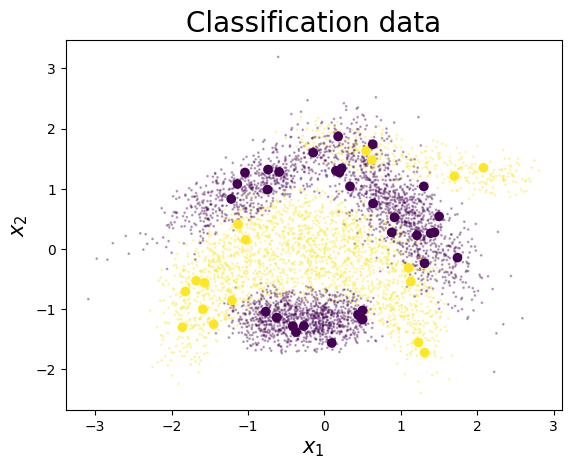

In [24]:
# Loading the data

import csv
XY = []
with open("./Data/banana.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        XY.append(row)
XY = np.array(XY)

# Here we select a subset of the data. (remember, computation scales as N^3)
np.random.seed(42)
np.random.shuffle(XY)
N = 50
X, Y = XY[:N,:-1], XY[:N,-1:]
Y = (Y-1.5) * 2 # to be in {-1, 1}
N = X.shape[0]

print("N =", N)
print(X.shape)
print(Y.shape)
# Plotting the data

plt.scatter(XY[:,0], XY[:,1], c=XY[:,2], s=1, alpha=0.3)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('Classification data', fontsize=20);

#### Implementing the kernel
To fully specify the model, we need the prior covariance $K_p = K_{\bf ff}$ and its Cholesky factor $L_p = chol(K_{\bf ff})$. As usual, the prior mean is zero. Your task here is to implement the standard RBF kernel, parametrized by the length scale $l$ and the kernel variance $\sigma^2$. Note that the x variables are 2D, meaning that some implementation details are different from the previous assignment. 

**Hyperparameter optimization.** Note that in addition to approximating $p(f|y)$, the ELBO can (optionally) be used to optimize the kernel hyperparameters $\{l,\sigma^2\}$ at the same time, because it is a lower bound to the marginal likelihood $p(y)$. To do this, the kernel has to be defined with Tensorflow functions to enable autodifferentiation and calculating gradients for the hyperparameters, which are defined as Tensorflow Variables. In addition, the two hyperparameters need to be parametrized so that they can not get negative values, which is achieved by optimizing their log-values instead (since, e.g., length scale should be in $[0,\infty]$, log length scale is unconstrained in $[-\infty,\infty]$). We will try out optimizing the hyperparameters later on, which is why the implementation below takes the hyperparameters in log-space. 

In [25]:
###############################################
# ------- insert code here -------------------
##############################################
def kernelmatrix(X1, X2, log_ell, log_sigma_squared):
    ell = tf.exp(log_ell)
    sigma_squared = tf.exp(log_sigma_squared)
    dist = tf.reduce_sum((X1[:, None, :] - X2[None, :, :])**2, axis=-1)
    kernel_matrix = sigma_squared * tf.exp(-dist / (ell**2))
    return kernel_matrix

def kernelmatrix_diagonal(X, log_sigma_squared):
    sigma_squared = tf.exp(log_sigma_squared)
    return sigma_squared * np.ones((len(X), 1))

In [26]:
# hereee
# dave

#### Optimizing the ELBO

Here we initialize the variational distribution to $q({\bf f})={\cal N}({\bf f};0, I)$,
then optimize it to maximize the ELBO using gradient based optimization. Gradient based optimization refers to optimization schemes where a function $f(\theta)$ is optimized with respect to $\theta$ by following the gradient $\nabla_{\theta} f(\theta)$. For example, gradient descent constructs a sequence of values $\theta_t$ following
$$\theta_{t+1 } = \theta_t - \eta \nabla_{\theta} f(\theta)|_{\theta=\theta_t}$$
where $\eta$ is the learning rate. Note that while we want to maximize the ELBO, the standard optimization helpers provided by Tensorflow are designed to minimize functions. Thus, ELBO maximization is implemented as negative ELBO minimization. 

**Note on autodiff.** When using an automatic differentiation framework, one does not need to manually derive the gradient (hence the 'automatic'). As discussed earlier, these frameworks include Tensorflow, Jax and Pytorch.

**Parametrization.** Note that the following code treats the $L_q$ parameters in a special way: Instead of optimizing over all of the $N\times N$ matrix elements, we only optimize over the lower triangular part. In addition, the diagonal elements are constrained to be positive by parametrizing the diagonal in log-space. The reason for this is that Cholesky factors are lower triangular with positive elements on the diagonal, and without forcing these properties, some elements in the upper diagonal could also be optimized to non-zero values or some diagonal elements could become negative. Thus, some of the ELBO calculations would not be quite correct as they assume valid Cholesky factors. This parametrization is achieved by having the $L_q$ lower triangular part in a vector and using a "bijector" from the tensorflow_probability package to transform into a lower triangular matrix in a way that preserves gradients. In addition, and exp transform is applied to the diagonal elements to define the final $L_q$ matrix, forcing positivity. See https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/FillTriangular, https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/TransformDiagonal and https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector if you are interested to learn more.

**Task.** Try to get familiar with the optimization function below and fill out the missing details. Then try running the optimization for $q(\mathbf f)$. At this stage, do not optimize hyperparameters yet. 

In [34]:
import tensorflow_probability as tfp
def optimize_elbo(ell, sigma_squared, optimize_hyperparams=False, print_progress=True):
    """ Optimize the variational posterior q(f) and (optionally) the length scale and variance hyperparameters.
    
    Arguments:
    ell -- The kernel effective length scale, or its initial value in case optimize_hyperparameters=True
    sigma_squared -- The kernel variance, or its initial value in case optimize_hyperparameters=True
    optimize_hyperparams -- Whether to optimize hyperparameters
    print_progress -- Whether to print out ELBO values during optimization
    
    Returns:
    m_q -- The mean vector of the optimized variational posterior
    L_q -- the Cholesky factor L_q of the covariance of the optimized variational posterior
    elbo_values -- The intermediate values of the ELBO during optimization
    log_ell -- The log effective length scale after optimization
    log_sigma_squared -- The log kernel variance after optimization
    """
    
    # Log-hyperparameters:
    v_log_ell = tf.Variable(np.log(ell), dtype=tf.float64)
    v_log_sigma_squared = tf.Variable(np.log(sigma_squared), dtype=tf.float64)
    
    # The prior mean and the Cholesky factor of the prior covariance
    K_p = kernelmatrix(X, X, v_log_ell, v_log_sigma_squared)
    # m_p = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
    m_p = np.zeros((N, 1))
    L_p = tf.linalg.cholesky(K_p)

    # Initial distribution parameters m_q, L_q
    m_q = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
    # As Cholesky factors are lower triangular with positive diagonals, we want to parametrize them as such. 
    # Here we use tfp.bijectors.FillTriangular to map the trainable parameters in L_q_params
    # to a lower-triangular matrix and tfp.bijectors.TransformDiagonal to map the diagonals to positive values.
    # L_q is initialized at the identity matrix (note the exp transform for the diagonals)
    # Could also initialize to np.linalg.cholesky(K_p) for potentially faster convergence.
    L_q_params = tf.Variable(tfp.math.fill_triangular_inverse(np.zeros((N,N))), dtype=tf.float64)
    filltriangular = tfp.bijectors.FillTriangular(upper=False)
    positivediagonal = tfp.bijectors.TransformDiagonal(diag_bijector=tfp.bijectors.Exp())
    transform = lambda x: positivediagonal(filltriangular(x))
    
    # Loss function if we don't do hyperparameter optimization
    loss_q = lambda: - elbo(m_p, L_p, m_q, transform(L_q_params), Y)
    # Loss function for hyperparameter optimization (the prior Cholesky factor changes at each step)
    loss_hp = lambda: - elbo(m_p, tf.linalg.cholesky(kernelmatrix(X, X, v_log_ell, v_log_sigma_squared)), m_q, transform(L_q_params), Y)

    # definition of a training step
    def create_train_step(loss, opt, trainable_variables):
        @tf.function  # this makes the optimisation loop much faster, but restricts what operations you can do within your code
        def train_step():
            with tf.GradientTape() as tape:
                tape.watch(trainable_variables)
                loss_value = loss()
            gradients = tape.gradient(loss_value, trainable_variables)
            opt.apply_gradients(zip(gradients, trainable_variables))
            return loss_value
        return train_step

    # you can change the optimizer or learning rate
    opt = tf.optimizers.Adam(learning_rate=0.001) 

    num_iterations = 30000 # you can change the number of steps as well

    loss = loss_hp if optimize_hyperparams else loss_q
    trainable_variables = [m_q, L_q_params, v_log_ell, v_log_sigma_squared] if optimize_hyperparams else [m_q, L_q_params]
    train_step = create_train_step(loss, opt, trainable_variables)
    neg_elbo_values = []
    # running the optimization
    for t in range(num_iterations):
        neg_elbo_value = train_step()
        neg_elbo_values.append(neg_elbo_value)
        if t % 500 == 0 and print_progress:
            print(t, loss().numpy())
    L_q = transform(L_q_params)
    return m_q, L_q, neg_elbo_values, v_log_ell, v_log_sigma_squared

**Run the model.** Run the model with the hyperparameters provided. 

In [35]:
# kernel parameters
ell = 0.5  # the length scale
sigma_squared = 3.0**2  # the kernel variance
m_q, L_q, neg_elbo_values, log_ell, log_sigma_squared = optimize_elbo(ell, sigma_squared, optimize_hyperparams=False, print_progress=False)

**Plotting the results.** Plot the evolution of the ELBO as a function function of iterations. The results will be further visualized in the next task.

Text(0.5, 0, 'Iteration')

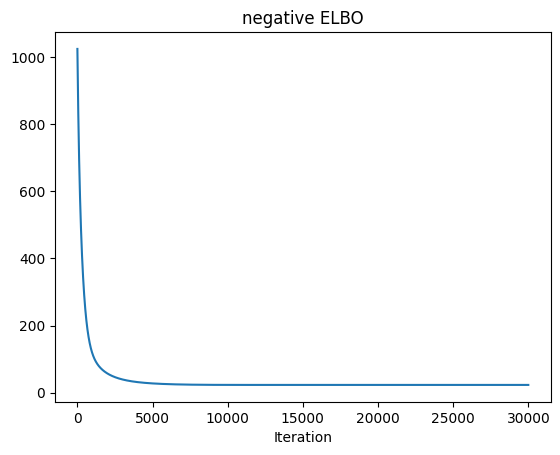

In [36]:
plt.plot(neg_elbo_values)
plt.title("negative ELBO")
plt.xlabel("Iteration")

### Task 1e: Posterior prediction for new data points

Under the hood, the algorithm defines a posterior process for all values of the input space.

For a new input $x^*$, the posterior prediction is given by 

$
\begin{align*}
q(f(x^*)) &= \int p(f(x^*)|{\bf f})q({\bf f})d{\bf f}\\
 &= {\cal N}(f(x^*)| K_{f^*{\bf f} }K_{{\bf ff}}^{-1} m_q,
 K_{f^*f^*} - K_{f^*{\bf f}}K_{{\bf ff}}^{-1}(K_{{\bf ff}} - S)K_{{\bf ff}}^{-1}K_{{\bf f} f^*})
\end{align*}
$

where $S$ is the optimized covariance and $\mathbf m_q$ is the optimized mean of $q(\mathbf f)$. Implement this function. 

In [37]:
def kernelmatrix_diagonal_vector(X1, X2, log_ell, log_sigma_squared):
    ell = tf.exp(log_ell)
    sigma_squared = tf.exp(log_sigma_squared)
    #dist_sq = (X1 - X2)**2
    dist_sq = tf.reshape(tf.reduce_sum((X1 - X2)**2, axis=1), [-1,1])
    #dist_sq = tf.reduce_sum(X1**2, axis=1, keepdims=True) + tf.reduce_sum(X2**2, axis=1) - 2 * tf.matmul(X1, X2, transpose_b=True)
    #print(dist_sq.shape)
    #print(X1.shape)
    kernel_matrix = sigma_squared * tf.exp(-dist_sq / (2 * (ell**2)))
    #print(kernel_matrix.shape)
    return kernel_matrix

In [38]:
def posterior_marginal_prediction(X_new, X, m_q, L_q, log_ell, log_sigma_squared):
    """ compute the posterior marginal predictions q(f(x*)) 
    independently for all inputs in X_new 
    
    Note: You need to now use tensorflow functions.
    
    arguments:
    X_new -- N_new × 2, matrix of new inputs
    X     -- N × 2, matrix of training inputs
    m_q   -- N × 1, mean vector of q
    L_q   -- N × N, Cholesky factor of the covariances of q
    log_ell -- log-length-scale of the kernel
    log_sigmasquared -- log-variance of the kernel
    returns: predictive marginal means and variances (both with size N_new × 1)
    """
    ### IMPORTANT
    # We should avoid computing the full N_new × N_new covariance matrix due to memory limitations.
    # You only need the diagonal values of this matrix for the predictive variances.
    # Could you implement an alternative to kernelmatrix() to do this?
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    # compute kernel matrices between training inputs and new inputs


    # MODEL SOLUTION #
    
    Kfs = kernelmatrix(X, X_new, log_ell, log_sigma_squared)
    Kff = kernelmatrix(X, X, log_ell, log_sigma_squared)
    Kss = kernelmatrix_diagonal(X_new, log_sigma_squared)
    KffInv_Kfs = tf.linalg.solve(Kff, Kfs)
    m = tf.matmul(KffInv_Kfs, m_q, transpose_a = True)
    S = tf.matmul(L_q, L_q, transpose_b = True)
    v = Kss - tf.reduce_sum(KffInv_Kfs * ((Kff - S) @ KffInv_Kfs), axis=0)[:, None]
    
    return m, v

To test your implementation of `posterior_marginal_prediction`, you can check whether you get back the correct marginals of $q({\bf f})$ when setting `X_new = X`:

In [39]:
def test_marginal_prediction(X, m_q, L_q):
    pred_mean, pred_var = posterior_marginal_prediction(X, X, m_q, L_q, log_ell, log_sigma_squared)
    np.testing.assert_allclose(pred_mean, m_q)
    S_diag = np.diag(L_q @ np.transpose(L_q))[:, None]

    np.testing.assert_allclose(pred_var, S_diag)

test_marginal_prediction(np.random.randn(5, 1), np.random.randn(5, 1), np.random.randn(5, 5))

For the likelihood
$$ p(y_i|f(\cdot),{\bf x}_i) = p(y_i|f_i) = \phi(y_i * f_i),$$
where $\phi$ is the cdf of the standard normal distribution, the integral $ p(y^*=1 | {\bf y}) \approx \int p(y^*=1 | f^*) q(f^*) \,{\rm d}f^* $
can be solved analytically for Gaussian $q(f^*)$. For $q(f^*) = \mathcal{N}(\mu, \sigma^2)$, we get
$$ \int p(y^* | f^*) q(f^*) \,{\rm d}f^* = \phi(\mu / \sqrt{1 + \sigma^2}) .$$
Alternatively, think about how you can re-use the `expected_log_likelihood` function!

Fill out the implementation of the y output probability given the corresponding GP mean and variance in the plotting code below. After that, try plotting the results!

In [40]:
# create new input points on grid
n_grid = 100
x = np.linspace(XY[:,0].min(), XY[:,1].max(), n_grid)

X1new, X2new = np.meshgrid(x, x)
Xnew = np.hstack([
  X1new.reshape(-1,1), X2new.reshape(-1,1)
])  # size : n_grid * n_grid x 2

In [41]:
import time
def plot_posterior(m_new, v_new):
    """
    Plots the posterior prediction for the grid in Xnew (global variable)
    
    arguments:
    m_new -- mean at Xnew
    v_new -- variance at Xnew
    """
    # first, compute marginal posterior over y from the posterior over f:
    ###############################################
    # ------- insert code here -------------------
    ###############################################


    Ypred = tf.divide(m_new, tf.sqrt(1 + tf.square(v_new)))
    #print(Ypred.shape)
    # y_new = expected_log_likelihood(m_new, v_new, classif_log_likelihood, Ypred, n_gh=20)
    # Model solution
    y_new = expected_log_likelihood(m_new, v_new, lambda f, _: phi(f), None)[:, None]
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.contour(x, x, m_new.numpy().reshape(n_grid,n_grid),
                cmap=plt.cm.RdBu_r, vmin=-np.abs(m_new).max(), vmax=np.abs(m_new).max())
    plt.colorbar()
    plt.title("Posterior mean")
    plt.subplot(1,3,2)
    plt.contour(x, x, v_new.numpy().reshape(n_grid,n_grid))
    plt.colorbar()
    plt.title("Posterior variance")
    plt.subplot(1,3,3)
    plt.contour(x, x, y_new.numpy().reshape(n_grid,n_grid),
                cmap=plt.cm.RdBu_r, vmin=0, vmax=1)
    plt.colorbar()
    plt.title("p(y|f)")
    plt.scatter(X[:,0], X[:,1], c=Y)  # training points

    #plt.scatter(XY[:,0], XY[:,1], c=XY[:,2], s=1, alpha=0.3)  # all data points
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())

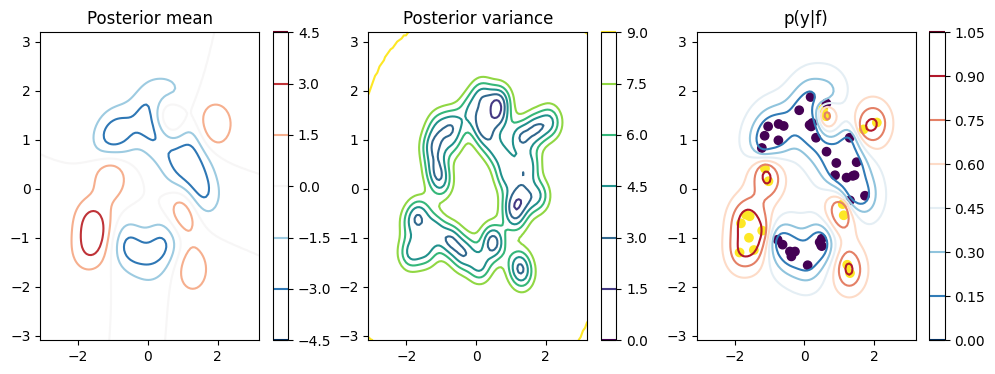

In [42]:
###############################################
# ------- insert code here -------------------
###############################################

m_new, v_new = posterior_marginal_prediction(Xnew, X, m_q, L_q, log_ell, log_sigma_squared)
plot_posterior(m_new, v_new)

### Task 1f: Repeat with different hyperparameter values! 
* Repeat the procedure for different values of $(\ell, \sigma^2)$, aside from $(0.5, 9)$. Can you see improvements or worse results? Does the ELBO correlate with good hyperparameter values in this example?
* Repeat the procedure, but this time setting optimize_hyperparameters=True and actually optimize the hyperparameters. Is the reached ELBO better than the values you got from the previous runs?

In [43]:
def optimize_elbo_new(ell, sigma_squared, optimize_hyperparams=False, print_progress=True):
    """ Optimize the variational posterior q(f) and (optionally) the length scale and variance hyperparameters.
    
    Arguments:
    ell -- The kernel effective length scale, or its initial value in case optimize_hyperparameters=True
    sigma_squared -- The kernel variance, or its initial value in case optimize_hyperparameters=True
    optimize_hyperparams -- Whether to optimize hyperparameters
    print_progress -- Whether to print out ELBO values during optimization
    
    Returns:
    m_q -- The mean vector of the optimized variational posterior
    L_q -- the Cholesky factor L_q of the covariance of the optimized variational posterior
    elbo_values -- The intermediate values of the ELBO during optimization
    log_ell -- The log effective length scale after optimization
    log_sigma_squared -- The log kernel variance after optimization
    """
    
    # Log-hyperparameters:
    v_log_ell = tf.Variable(np.log(ell), dtype=tf.float64)
    v_log_sigma_squared = tf.Variable(np.log(sigma_squared), dtype=tf.float64)
    
    # The prior mean and the Cholesky factor of the prior covariance
    K_p = kernelmatrix(X, X, v_log_ell, v_log_sigma_squared)
    m_p = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
    L_p = tf.linalg.cholesky(K_p)

    m_q = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
    # As Cholesky factors are lower triangular with positive diagonals, we want to parametrize them as such. 
    # Here we use tfp.bijectors.FillTriangular to map the trainable parameters in L_q_params
    # to a lower-triangular matrix and tfp.bijectors.TransformDiagonal to map the diagonals to positive values.
    # L_q is initialized at the identity matrix (note the exp transform for the diagonals)
    # Could also initialize to np.linalg.cholesky(K_p) for potentially faster convergence.
    L_q_params = tf.Variable(tfp.math.fill_triangular_inverse(np.zeros((N,N))), dtype=tf.float64)
    filltriangular = tfp.bijectors.FillTriangular(upper=False)
    positivediagonal = tfp.bijectors.TransformDiagonal(diag_bijector=tfp.bijectors.Exp())
    transform = lambda x: positivediagonal(filltriangular(x))
    
    # Loss function if we don't do hyperparameter optimization
    loss_q = lambda: - elbo(m_p, L_p, m_q, transform(L_q_params), Y)
    # Loss function for hyperparameter optimization (the prior Cholesky factor changes at each step)
    loss_hp = lambda: - elbo(m_p, tf.linalg.cholesky(kernelmatrix(X, X, v_log_ell, v_log_sigma_squared)), m_q, transform(L_q_params), Y)

    # definition of a training step
    def create_train_step(loss, opt, trainable_variables):
        @tf.function  # this makes the optimisation loop much faster, but restricts what operations you can do within your code
        def train_step():
            with tf.GradientTape() as tape:
                tape.watch(trainable_variables)
                loss_value = loss()
            gradients = tape.gradient(loss_value, trainable_variables)
            opt.apply_gradients(zip(gradients, trainable_variables))
            return loss_value
        return train_step

    # you can change the optimizer or learning rate
    opt = tf.optimizers.Adam(learning_rate=0.001) 

    num_iterations = 2000 # you can change the number of steps as well

    loss = loss_hp if optimize_hyperparams else loss_q
    trainable_variables = [m_q, L_q_params, v_log_ell, v_log_sigma_squared] if optimize_hyperparams else [m_q, L_q_params]
    train_step = create_train_step(loss, opt, trainable_variables)
    neg_elbo_values = []
    # running the optimization
    for t in range(num_iterations):
        neg_elbo_value = train_step()
        neg_elbo_values.append(neg_elbo_value)
        if t % 500 == 0 and print_progress:
            print(t, loss().numpy())
    L_q = transform(L_q_params)
    return m_q, L_q, neg_elbo_values, v_log_ell, v_log_sigma_squared

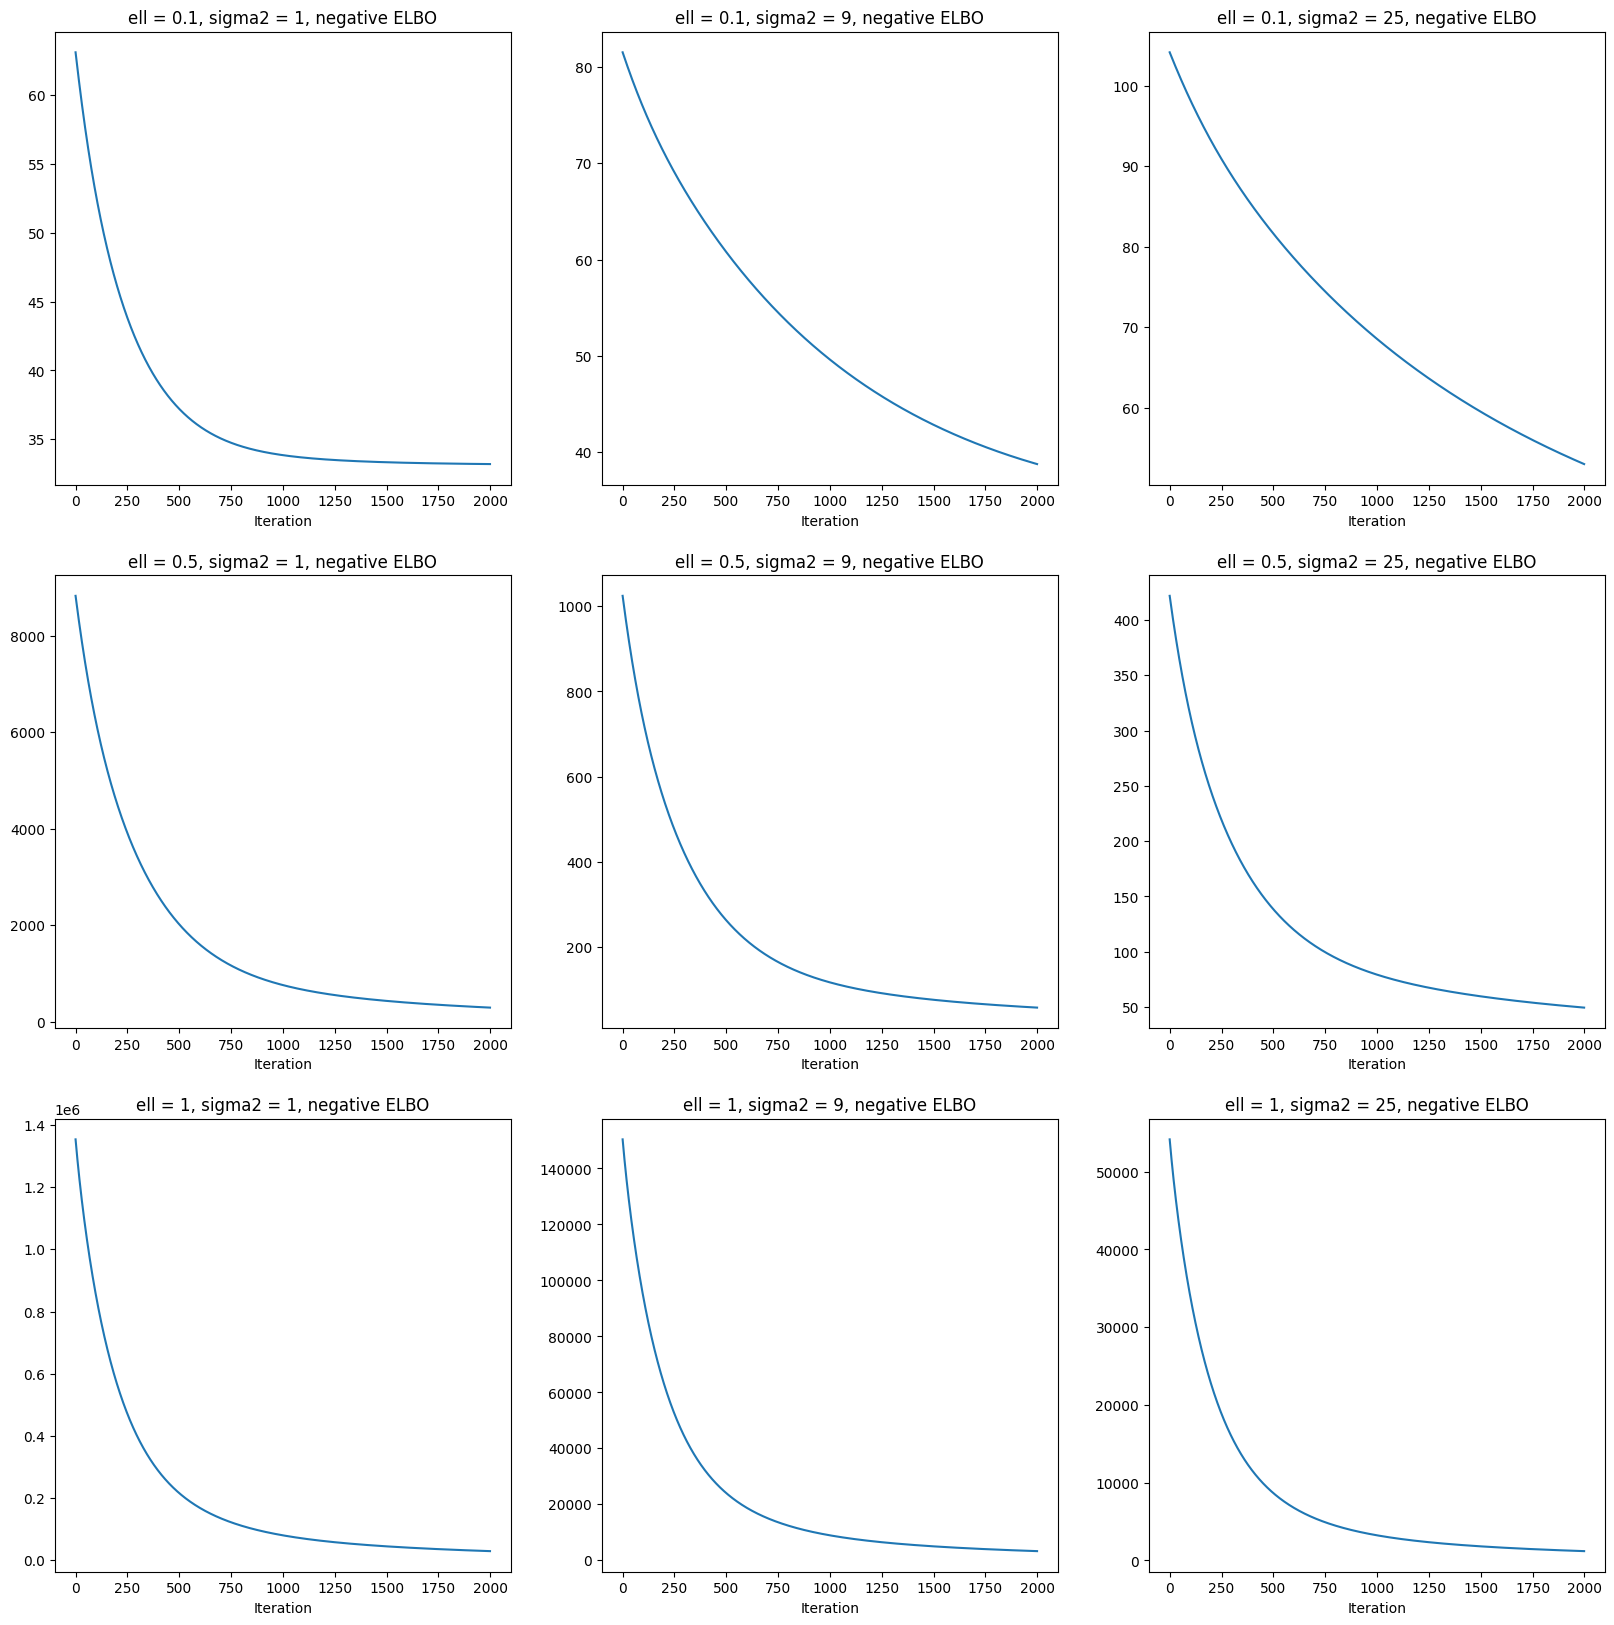

In [44]:
fig,ax=plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
ells = [0.1, 0.5, 1]  # the length scale
sigma_squareds = [1**2, 3**2, 5**2]  # the kernel variance

for indexEll, ell in enumerate(ells):
    for indexSigma, sigma_squared in enumerate(sigma_squareds):
        m_q, L_q, neg_elbo_values, log_ell, log_sigma_squared = optimize_elbo_new(ell, sigma_squared, optimize_hyperparams=False, print_progress=False)
        ax[indexEll][indexSigma].plot(neg_elbo_values)
        ax[indexEll][indexSigma].set_title(f"ell = {ell}, sigma2 = {sigma_squared}, negative ELBO")
        ax[indexEll][indexSigma].set_xlabel("Iteration")

=> The ELBO really correlates with good hyperparameter values in this example. It can be seen that the optimal hyperparameter values among the figures is ell = 1 and sigma_squared = 1

The optimal hyperparameter ell value: 0.7398657128131967
The optimal hyperparameter sigma2 value: 35.84141753547661


Text(0.5, 0, 'Iteration')

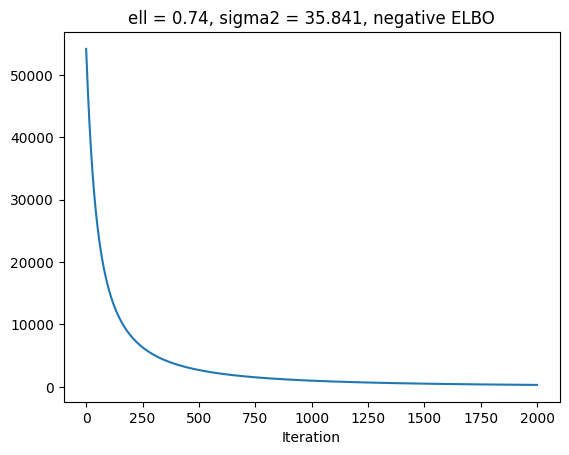

In [45]:
m_q, L_q, neg_elbo_values, log_ell, log_sigma_squared = optimize_elbo_new(ell, sigma_squared, optimize_hyperparams=True, print_progress=False)
print("The optimal hyperparameter ell value:", np.exp(log_ell))
print("The optimal hyperparameter sigma2 value:", np.exp(log_sigma_squared))
plt.plot(neg_elbo_values)
plt.title(f"ell = {round(np.exp(log_ell),3)}, sigma2 = {round(np.exp(log_sigma_squared),3)}, negative ELBO")
plt.xlabel("Iteration")

Conclusion: the reached ELBO is much better than the values from the previous runs, where the rate of convergence is the most rapid. 

# Task 2 - GPs with PyMC for Flu 

In practice, it does not make too much sense to use a GP to model a problem we can just solve with a logistic regression. Instead, we want to use a GP to model more complex data that ist not well captured with less flexible models. In the following, we will model the probability of getting a disease as a function of age. It turns out that young and very old people have a higher risk than people of middle age. 

The dataset `space_flu.csv` is a synthetic dataset inspired by the previous description. 

[Text(0, 0, 'healthy'), Text(0, 1, 'sick')]

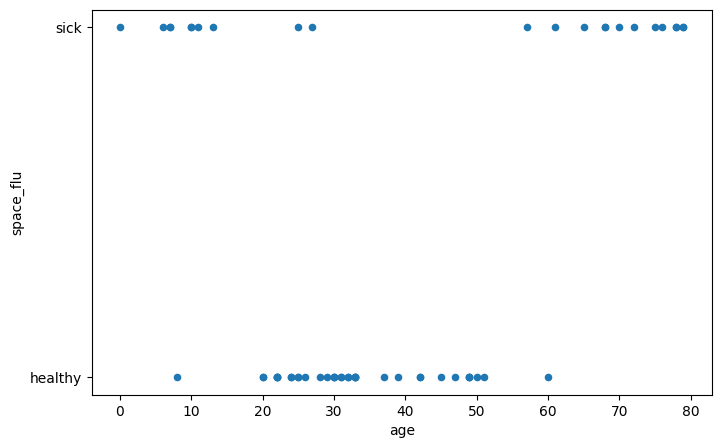

In [46]:
import pandas as pd

df_sf = pd.read_csv('Data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu
ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])

**Task 2a:** Define with PyMC a Gaussian process classification model to predict whether a person will be `healthy` or `sick` depending on the `age`.

In [47]:
import pymc as pm
import preliz as pz
import arviz as az
import numpy as np
from scipy.special import expit as logistic
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.95, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [48]:
###############################################
# ------- insert code here -------------------
###############################################

with pm.Model() as model_space_flu:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(age))
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    idata_space_flu = pm.sample(nuts_sampler="nutpie", random_seed=123)

/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py:121: UserWarning: A Supervisor feature is missing from FunctionGraph(AdvancedSetSubtensor(Alloc(0.0, *2 -> Shape_i{0}(*0-<Vector(float64, shape=(?,))>), *2), *0-<Vector(float64, shape=(?,))>, *1 -> ARange{dtype='int64'}(0, *2, 1), *1)).
  return self.apply(fgraph, *args, **kwargs)
/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py:121: UserWarning: A Supervisor feature is missing from FunctionGraph(AdvancedSetSubtensor(Alloc(0.0, *2 -> Shape_i{0}(*0-<Vector(float64, shape=(?,))>), *2), *0-<Vector(float64, shape=(?,))>, *1 -> ARange{dtype='int64

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.57,7
,2000,0,0.59,7
,2000,0,0.58,7
,2000,0,0.58,7


In [49]:
X_new = np.linspace(0, 80, 200)[:, None]

    
with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new) 
    idata_space_flu_subset = idata_space_flu.sel(draw=slice(0, None, 100))
    pred_samples_flu = pm.sample_posterior_predictive(idata_space_flu_subset, var_names=["f_pred"], random_seed=123)


f_pred_space_flu = (pred_samples_flu.
                    posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].
                    values)

Sampling: [f_pred]


Output()

/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0.5, 0, 'age')

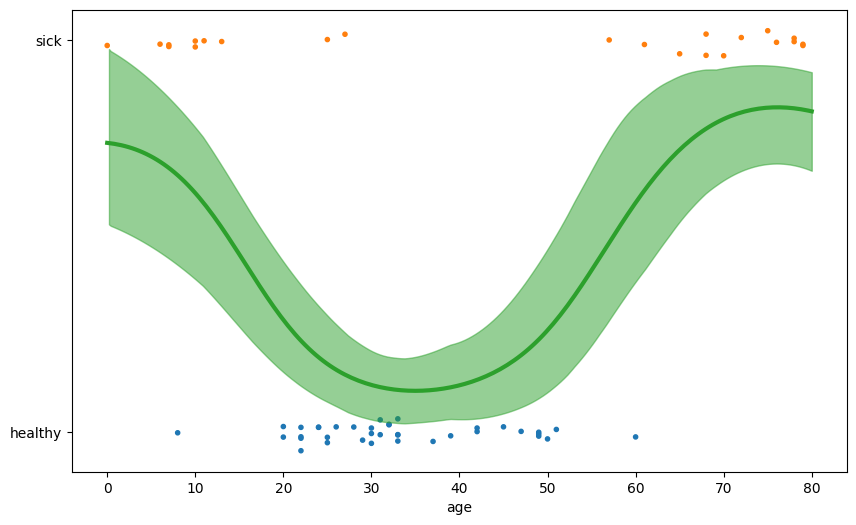

In [50]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(f_pred_space_flu)
fp_mean = np.nanmean(fp, 1)

ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)

az.plot_hdi(X_new[:, 0], fp.T, color='C2', smooth=True)
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')

**Task 2b:** Run a logistic model for the `space_flu` data. What do you see? Can you explain the result?
_Optional_: Change the logistic regression model by using an order 2 polynomial. 

In [51]:
###############################################
# ------- insert code here -------------------
###############################################

with pm.Model() as model_lrs_flu:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=5)
    μ = α + age.ravel() * β
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -α / β)
    yl = pm.Bernoulli("yl", p=θ, observed=space_flu.values)
    idata_lrs_flu = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


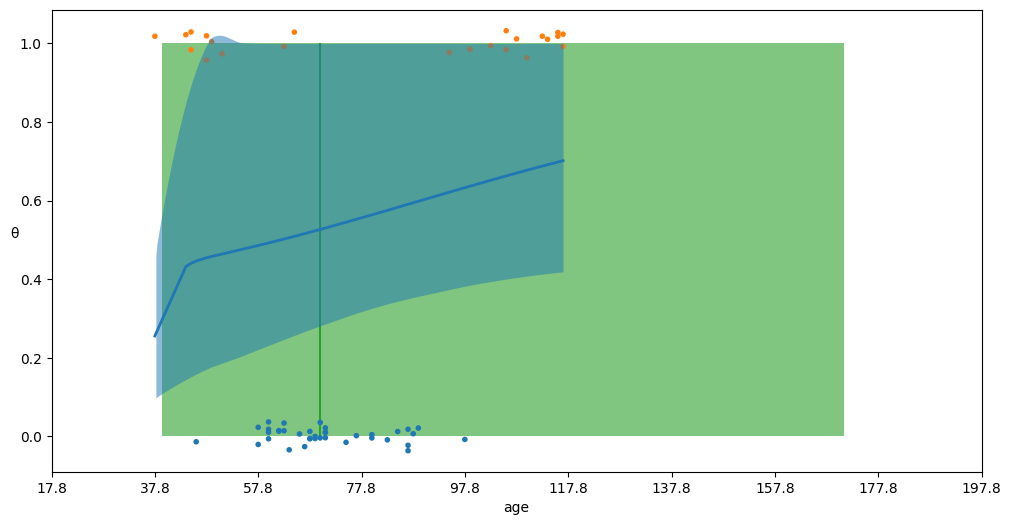

In [52]:
age = age.ravel()
space_flu = space_flu.values
posterior = idata_lrs_flu.posterior
theta = posterior["θ"].mean(("chain", "draw"))
idx = np.argsort(age)

_, ax = plt.subplots(figsize=(12, 6))

ax.plot(age[idx], theta[idx], color="C0", lw=2)
ax.vlines(posterior["bd"].mean(("chain", "draw")), 0, 1, color="C2", zorder=0)
bd_hdi = az.hdi(posterior["bd"])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color="C2", alpha=0.6, lw=0)
ax.scatter(age, np.random.normal(space_flu, 0.02), marker=".", color=[f"C{x}" for x in space_flu])
az.plot_hdi(age, posterior["θ"], color="C0", ax=ax, fill_kwargs={"lw": 0})
ax.set_xlabel("age")
ax.set_ylabel("θ", rotation=0)
# # use original scale for xticks
locs, _ = plt.xticks()
ax.set_xticks(locs, np.round(locs + age.mean(), 1))

# Task 3 - GPs with PyMC for Count Data

The _coal mining distasters_ dataset consists of a record of coal-mining disasters in the UK from 1851 to 1962. The number of disasters thought to have been affected by changes in safety regulations during this period. We want to model the rate of disasters as a function of time. Our dataset consists of a single column and each entry corresponds to the time a disaster happened. 

In [53]:
coal_df = pd.read_csv('Data/coal.csv', header=None)
coal_df.head()

,0
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142


You may be wondering at this point how we are going to perform a regression if we only have a single column with just the date of the disasters. The answer is to discretize the data, just as if we were building a histogram. We are going to use the centers of the bins as the $X$ variable and the counts per bin as the $Y$ variable.

In [54]:
# discretize data
years = int((coal_df.max() - coal_df.min()).iloc[0])
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist

**Task 3a:** Use the following model to fit the data:

\begin{equation*}
f(X)= \mathcal{GP}(\mu_X, K(X, X'))
y=\text{Pois}(f(X))
\end{equation*}

This is a Poisson regression problem where a Poisson likelihood is used and the rate is modeled using a Gaussian process. Because the rate of the Poisson distribution is limited to positive values, we will use an exponential as the _inverse link function_. When the rate of the Poisson process is itself a stochastic process, such as for example a Gaussian process, then we have a _Cox process_.

Define and solve the model with PyMC.

_Hint_: Use `pm.Poisson()` as likelihood function.

In [55]:
###############################################
# ------- insert code here -------------------
###############################################

with pm.Model() as model_coal:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(x_edges))
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)

    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    idata_coal = pm.sample(nuts_sampler="nutpie", random_seed=123)

/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py:121: UserWarning: A Supervisor feature is missing from FunctionGraph(AdvancedSetSubtensor(Alloc(0.0, *2 -> Shape_i{0}(*0-<Vector(float64, shape=(?,))>), *2), *0-<Vector(float64, shape=(?,))>, *1 -> ARange{dtype='int64'}(0, *2, 1), *1)).
  return self.apply(fgraph, *args, **kwargs)
/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py:121: UserWarning: A Supervisor feature is missing from FunctionGraph(AdvancedSetSubtensor(Alloc(0.0, *1 -> Shape_i{0}(*0-<Vector(float64, shape=(?,))>), *1), *0-<Vector(float64, shape=(?,))>, *2 -> ARange{dtype='int64

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.31,15
,2000,0,0.30,15
,2000,0,0.29,15
,2000,0,0.30,15


/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'rate')

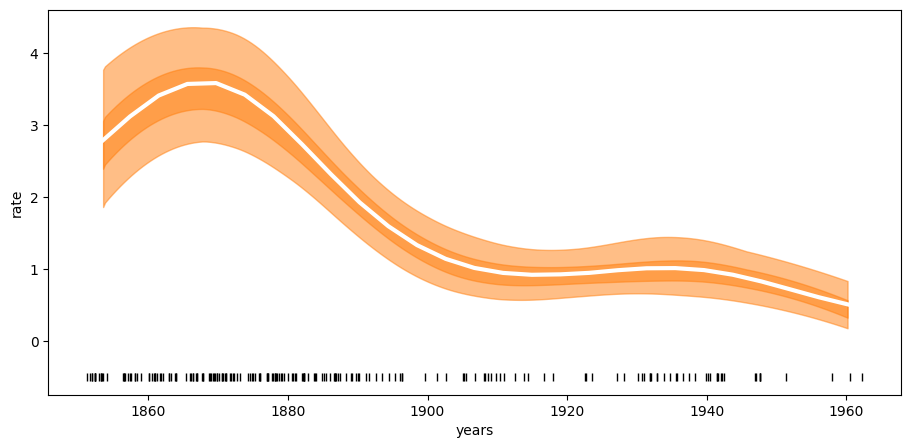

In [56]:
_, ax = plt.subplots(figsize=(11, 5))

f_trace = np.exp(idata_coal.posterior['f'].stack(samples=("chain", "draw")).T) / 4
rate_median = np.median(f_trace, axis=0)

ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hdi(x_centers, f_trace)

az.plot_hdi(x_centers, f_trace, hdi_prob=0.5,
            plot_kwargs={'alpha': 0})

ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate')

The above figure shows the median disasters as a function of time (white line). The bands describe the 50% HDI (darker orange) and the 94% HDI (lighter orange). At the bottom, the black markers indicate the moment of each disaster. As we can see, the rate of accidents decreases with time, except for a brief initial increase

**Task 3b (Optional):** Compare the above model for the coal mining disaster with the following one. Describe the differences between both models in terms of model specification and results.

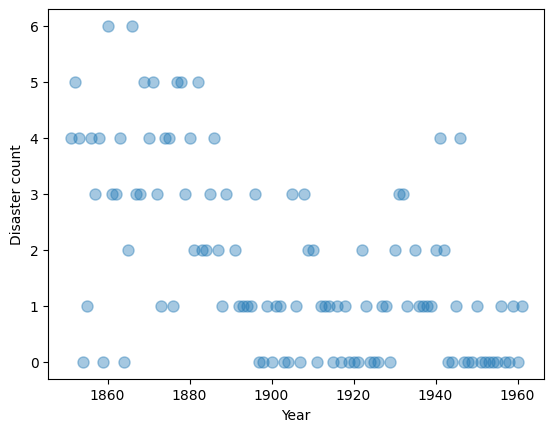

In [57]:
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

Occurrences of disasters in the time series are thought to follow a Poisson process with a high rate parameter in the early part of the time series, and a lower rate parameter in the later part. We are interested in locating the change point in the series, which may be related to changes in mining safety regulations. Our model is given by: 

\begin{align*}
D_t & \sim \text{Pois}(r_t)\quad\text{with}\quad r_t=e\quad\text{if}\quad t\leq s\quad\text{else} \quad r_t=l\\
s & \sim \text{Unif}(t_l, t_h)\\
e & \sim \exp{(1)}\\
l & \sim \exp{(1)}
\end{align*}

In our model, the parameters are defined as follows:

- $D_t$: The number of disasters in year $t$
- $\lambda_t$: The rate parameter of the Poisson distribution of disasters in year $t$
- $s$: The year in which the rate parameter changes (the switchpoint)
- $\lambda_{\text{early}}$: The rate parameter before the switchpoint $t < s$
- $\lambda_{\text{late}}$: The rate parameter after the switchpoint $(t \geq s$)
- $T_{\text{min}}$, $T_{\text{max}}$: The lower and upper boundaries of year $t$

This model is constructed similarly to previous model. The primary differences are:


**Describe the differences to the previous model here!**


- The _introduction of discrete variables_ with Poisson and discrete-uniform priors
- A _deterministic random variable_ that allows us to model the switchpoint where the rate of disasters changes

By capturing these elements, the model aims to detect where the rate of disasters might change, potentially reflecting the impact of safety regulations over time.

In [58]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/pymc/model/core.py:1264: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/pymc/model/core.py:1278: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


- `pm.math.switch` is a function that works like an if statement. It uses the first argument to switch between the next two arguments.

- Missing values are handled transparently by passing a NumPy `MaskedArray` or a `DataFrame` with NaN values to the observed argument when creating an observed stochastic random variable. Behind the scenes, another random variable, `disasters.missing_values` is created to model the missing values

- Unfortunately, because they are discrete variables and thus have no meaningful gradient, we cannot use NUTS for sampling switchpoint or the missing disaster observations. Instead, we will sample using a Metropolis step method, which implements adaptive Metropolis-Hastings, because it is designed to handle discrete values. PyMC automatically assigns the correct sampling algorithms.

In [59]:
with disaster_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_unobserved]
>NUTS: [early_rate, late_rate]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 4 seconds.


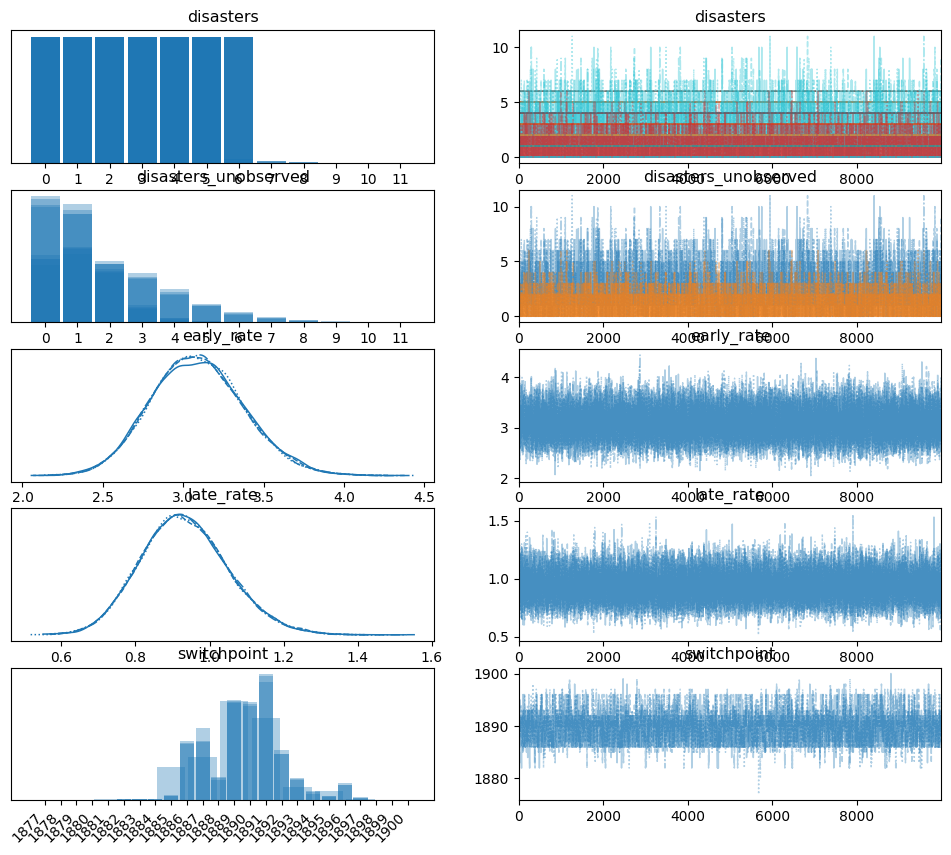

In [60]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

In the trace plots above we can see that there’s about a 10 year span that’s plausible for a significant change in safety, but a 5 year span that contains most of the probability mass. The distribution is jagged because of the jumpy relationship between the year switchpoint and the likelihood; the jaggedness is not due to sampling error.

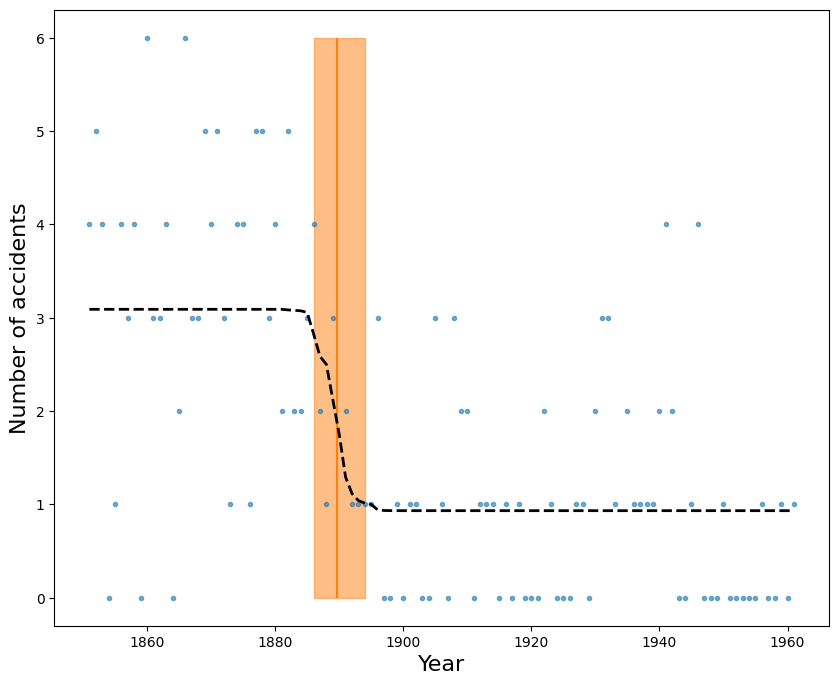

In [61]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);

The above plot shows the switch point as an orange vertical line, together with its highest posterior density (HPD) as a semitransparent band. The dashed black line shows the accident rate.